In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from sentinelhub import BBoxSplitter, BBox, CRS, DataCollection
import geopandas as gpd
import pandas as pd
from pathlib import Path
from shapely.geometry import Polygon


In [3]:
bayern = gpd.read_file("./bayern_l.geojson")

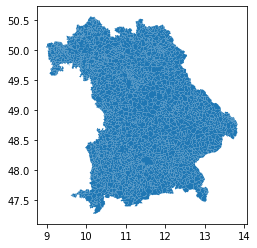

In [4]:
bayern.plot()

In [5]:
bayern.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
bayern_crs = CRS.UTM_32N
bayern = bayern.to_crs(crs = bayern_crs.pyproj_crs())


cities_name = bayern.GEN.tolist()
aoi_name = list(filter(lambda x: re.match(r"M(ue|ü)nchen",x) != None, cities_name))

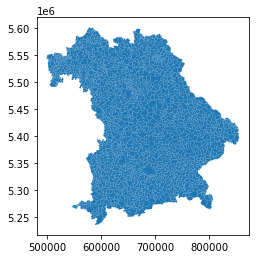

In [7]:
bayern.plot()

In [8]:
bayern.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [40]:
a = bayern.geometry.tolist()[20]
a 
type(a)

shapely.geometry.polygon.Polygon

In [56]:
a = 
type(a)

shapely.geometry.polygon.Polygon

In [46]:
Polygon(munich.geometry[1]

KeyError: 1

In [61]:
# Get the polygon of AOI
# here we use munich

munich = bayern[bayern.GEN == aoi_name[0]]
munich.geometry = munich.geometry.buffer(500)
# !here can't use munich.geometry, it will return geopandas.
munich_shape = munich.geometry.tolist()[0]


In [62]:
# Estimate the size of Area Of Interest 
print(munich_shape.bounds)
# Dimension of Area by m^2
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(munich_shape.bounds[2]-munich_shape.bounds[0],munich_shape.bounds[3]-munich_shape.bounds[1]))
# Dimension of Area by pixels
width_pix = int((munich_shape.bounds[2]-munich_shape.bounds[0])/10)
height_pix = int((munich_shape.bounds[3]-munich_shape.bounds[1])/10)
print('Dimension of the area is {} x {} pixels'.format(width_pix, height_pix))

(675066.9762764213, 5325751.263235999, 703083.9472842653, 5347402.236996037)
Dimension of the area is 28017 x 21651 m2
Dimension of the area is 2801 x 2165 pixels


303

In [63]:
# splite area into small bbox
bbox_splitter = BBoxSplitter([munich_shape], bayern_crs, (25, 17))
print(f'Area bounding box: {bbox_splitter.get_area_bbox().__repr__()}\n')

# get bbox list and information
bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

print('Each bounding box also has some info how it was created. Example:\n'
      '\nbbox: {}\ninfo: {}\n'.format(bbox_list[0].__repr__(), info_list[0]))

Area bounding box: BBox(((675066.9762764213, 5325751.263235999), (703083.9472842653, 5347402.236996037)), crs=CRS('32632'))

Each bounding box also has some info how it was created. Example:

bbox: BBox(((675066.9762764213, 5334666.370078368), (676187.6551167351, 5335939.956770135)), crs=CRS('32632'))
info: {'parent_bbox': BBox(((675066.9762764213, 5325751.263235999), (703083.9472842653, 5347402.236996037)), crs=CRS('32632')), 'index_x': 0, 'index_y': 7}



### Save box file


In [64]:
import pickle

if not os.path.isdir('./tile-definition'):
    os.makedirs('./tile-definition')

with open('./tile-definition/bayern_buffered_bbox_17x25.pickle','wb') as fp:
    pickle.dump(bbox_splitter, fp)

In [66]:
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
idxs_y = [info['index_y'] for info in bbox_splitter.info_list]

df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
common_crs = bbox_splitter.bbox_list[0].crs
gdf = gpd.GeoDataFrame(df, crs=common_crs.pyproj_crs(), geometry=geometry)
gdf

index_x  index_y                                           geometry
0          0        7  POLYGON ((675066.976 5334666.370, 675066.976 5...
1          0        8  POLYGON ((675066.976 5335939.957, 675066.976 5...
2          0        9  POLYGON ((675066.976 5337213.543, 675066.976 5...
3          0       10  POLYGON ((675066.976 5338487.130, 675066.976 5...
4          1        5  POLYGON ((676187.655 5332119.197, 676187.655 5...
..       ...      ...                                                ...
298       24        4  POLYGON ((701963.268 5330845.610, 701963.268 5...
299       24        5  POLYGON ((701963.268 5332119.197, 701963.268 5...
300       24        6  POLYGON ((701963.268 5333392.783, 701963.268 5...
301       24        7  POLYGON ((701963.268 5334666.370, 701963.268 5...
302       24        8  POLYGON ((701963.268 5335939.957, 701963.268 5...

[303 rows x 3 columns]

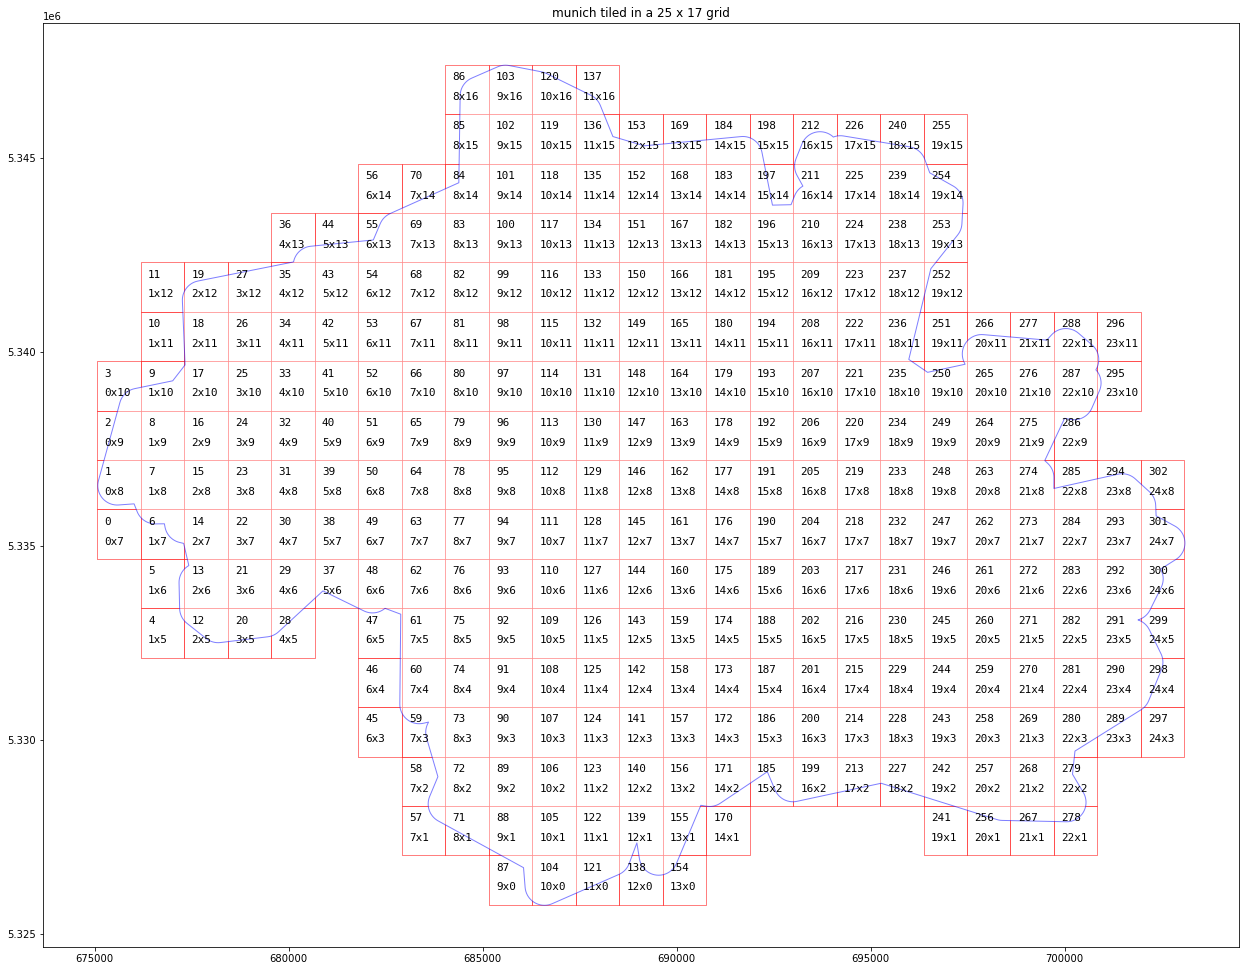

In [68]:
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}
# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu-xl)/3, (yu-yl)/5
# figure
fig, ax = plt.subplots(figsize=(25,17))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
munich.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('munich tiled in a 25 x 17 grid');
# add annotiation text
for idx in gdf.index:
    eop_name = '{0}x{1}'.format(gdf.index_x[idx], gdf.index_y[idx])
    centroid, = list(gdf.geometry[idx].centroid.coords)
    ax.text(centroid[0]-xoff, centroid[1]+yoff, '{}'.format(idx), fontdict=fontdict)
    ax.text(centroid[0]-xoff, centroid[1]-yoff, eop_name, fontdict=fontdict)

if not os.path.isdir('./figs'):
    os.makedirs('./figs')
fig.savefig('./figs/aoi_to_tiles.png', bbox_inches='tight')